# SEGUNDA ENTREGA ANALITICA
Susana Barrientos -
Fabio Gónzalez -
Javier Burgos

In [367]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


%matplotlib inline

### Dataset 1 FIFA
Fuente: https://sports-statistics.com/sports-data/fifa-2022-dataset-csvs/

#### Lectura de datos

In [368]:
df = pd.read_csv("https://raw.githubusercontent.com/JavierBurgos-web/PROYECTO_ANALITICA_2da_entrega/main/FIFA_22.csv", sep=";", encoding="ISO-8859-1")
df.head(3)

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1     188545  https://sofifa.com/player/188545/robert-lewand...   
2      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   

          short_name                            long_name player_positions  \
0           L. Messi       Lionel Andrés Messi Cuccittini       RW, ST, CF   
1     R. Lewandowski                   Robert Lewandowski               ST   
2  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro           ST, LW   

   overall  potential    value_eur  wage_eur  age  ...   lcb    cb   rcb  \
0       93         93   78000000.0  320000.0   34  ...  50+3  50+3  50+3   
1       92         92  119500000.0  270000.0   32  ...  60+3  60+3  60+3   
2       91         91   45000000.0  270000.0   36  ...  53+3  53+3  53+3   

     rb    gk                                    player_face_url  \
0  61+3  19+3  https://cdn.sofifa.net/players/158/023/22_120.png   
1  61+3  19+3  https://cdn.sofifa.net/players/188/545/22_120.png   
2  60+3  20+3  https://cdn.sofifa.net/players/020/801/22_120.png   

                            club_logo_url  \
0  https://cdn.sofifa.net/teams/73/60.png   
1  https://cdn.sofifa.net/teams/21/60.png   
2  https://cdn.sofifa.net/teams/11/60.png   

                             club_flag_url  \
0      https://cdn.sofifa.net/flags/fr.png   
1      https://cdn.sofifa.net/flags/de.png   
2  https://cdn.sofifa.net/flags/gb-eng.png   

                            nation_logo_url  \
0  https://cdn.sofifa.net/teams/1369/60.png   
1  https://cdn.sofifa.net/teams/1353/60.png   
2  https://cdn.sofifa.net/teams/1354/60.png   

                       nation_flag_url  
0  https://cdn.sofifa.net/flags/ar.png  
1  https://cdn.sofifa.net/flags/pl.png  
2  https://cdn.sofifa.net/flags/pt.png  

[3 rows x 110 columns]

In [369]:
#Información general de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(18), int64(44), object(48)
memory usage: 16.1+ MB


#### Tratamiento para nulos y eliminación de variables que no aportan al modelo

In [370]:
#Identificación de variables con mas de un 80% de valores nulos
df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

value_eur                     0.384635
wage_eur                      0.317064
club_team_id                  0.317064
club_name                     0.317064
league_name                   0.317064
league_level                  0.317064
club_position                 0.317064
club_jersey_number            0.317064
club_loaned_from             94.272052
club_joined                   6.045013
club_contract_valid_until     0.317064
nation_team_id               96.054889
nation_position              96.054889
nation_jersey_number         96.054889
release_clause_eur            6.112584
player_tags                  92.510006
player_traits                51.151307
pace                         11.081657
shooting                     11.081657
passing                      11.081657
dribbling                    11.081657
defending                    11.081657
physic                       11.081657
goalkeeping_speed            88.918343
lw                            1.694475
rw                       

In [371]:
#Eliminación de variables con mas de un 80% de valores nulos
df = df.drop(columns = ['nation_logo_url','player_tags','player_traits',
                        'nation_jersey_number','nation_position','nation_team_id','club_loaned_from',
                       'goalkeeping_speed','club_name','short_name','club_name','league_name','player_positions'])

In [372]:
#Eliminacion de variables que no aportan al modelo

df = df.drop(columns = ['player_url','long_name','nationality_id','player_face_url',
                        'club_logo_url','club_flag_url','nation_flag_url','body_type', 'real_face',
                        'sofifa_id', 'rw', 'lw','dob','club_jersey_number','club_team_id','league_level','potential','club_joined',
                        'club_contract_valid_until','nationality_name','work_rate'])

In [373]:
df = df.drop(columns = ['gk','rb','rcb','cb','lcb',
                        'lb','rwb','rdm','cdm', 'ldm',
                        'lwb', 'rm', 'rcm','cm','lcm',
                        'lm','ram','cam','lam','rf','cf',
                        'ls','st','rs','lf'])

In [374]:
df.isnull().sum()

overall                           0
value_eur                        74
wage_eur                         61
age                               0
height_cm                         0
weight_kg                         0
club_position                    61
preferred_foot                    0
weak_foot                         0
skill_moves                       0
international_reputation          0
release_clause_eur             1176
pace                           2132
shooting                       2132
passing                        2132
dribbling                      2132
defending                      2132
physic                         2132
attacking_crossing                0
attacking_finishing               0
attacking_heading_accuracy        0
attacking_short_passing           0
attacking_volleys                 0
skill_dribbling                   0
skill_curve                       0
skill_fk_accuracy                 0
skill_long_passing                0
skill_ball_control          

In [375]:
##tratamiento para nulos
median_physic = df['physic'].median()
median_defending = df['defending'].median()
median_dribbling = df['dribbling'].median()
median_passing = df['passing'].median()
median_shooting = df['shooting'].median()
median_pace = df['pace'].median()
median_release_clause_eur = df['release_clause_eur'].median()
median_wage_eur = df['wage_eur'].median()
median_value_eur  = df['value_eur'].median()
mode_club_position = df['club_position'].mode().iloc[0]

df['physic'].fillna(median_physic, inplace=True)
df['defending'].fillna(median_defending, inplace=True)
df['dribbling'].fillna(median_dribbling, inplace=True)
df['passing'].fillna(median_passing, inplace=True)
df['shooting'].fillna(median_shooting, inplace=True)
df['pace'].fillna(median_pace, inplace=True)
df['release_clause_eur'].fillna(median_release_clause_eur, inplace=True)
df['wage_eur'].fillna(median_wage_eur, inplace=True)
df['value_eur'].fillna(median_value_eur, inplace=True)
df['club_position'].fillna(mode_club_position, inplace=True)

In [376]:
df.isnull().sum()

overall                        0
value_eur                      0
wage_eur                       0
age                            0
height_cm                      0
weight_kg                      0
club_position                  0
preferred_foot                 0
weak_foot                      0
skill_moves                    0
international_reputation       0
release_clause_eur             0
pace                           0
shooting                       0
passing                        0
dribbling                      0
defending                      0
physic                         0
attacking_crossing             0
attacking_finishing            0
attacking_heading_accuracy     0
attacking_short_passing        0
attacking_volleys              0
skill_dribbling                0
skill_curve                    0
skill_fk_accuracy              0
skill_long_passing             0
skill_ball_control             0
movement_acceleration          0
movement_sprint_speed          0
movement_a

<Axes: >

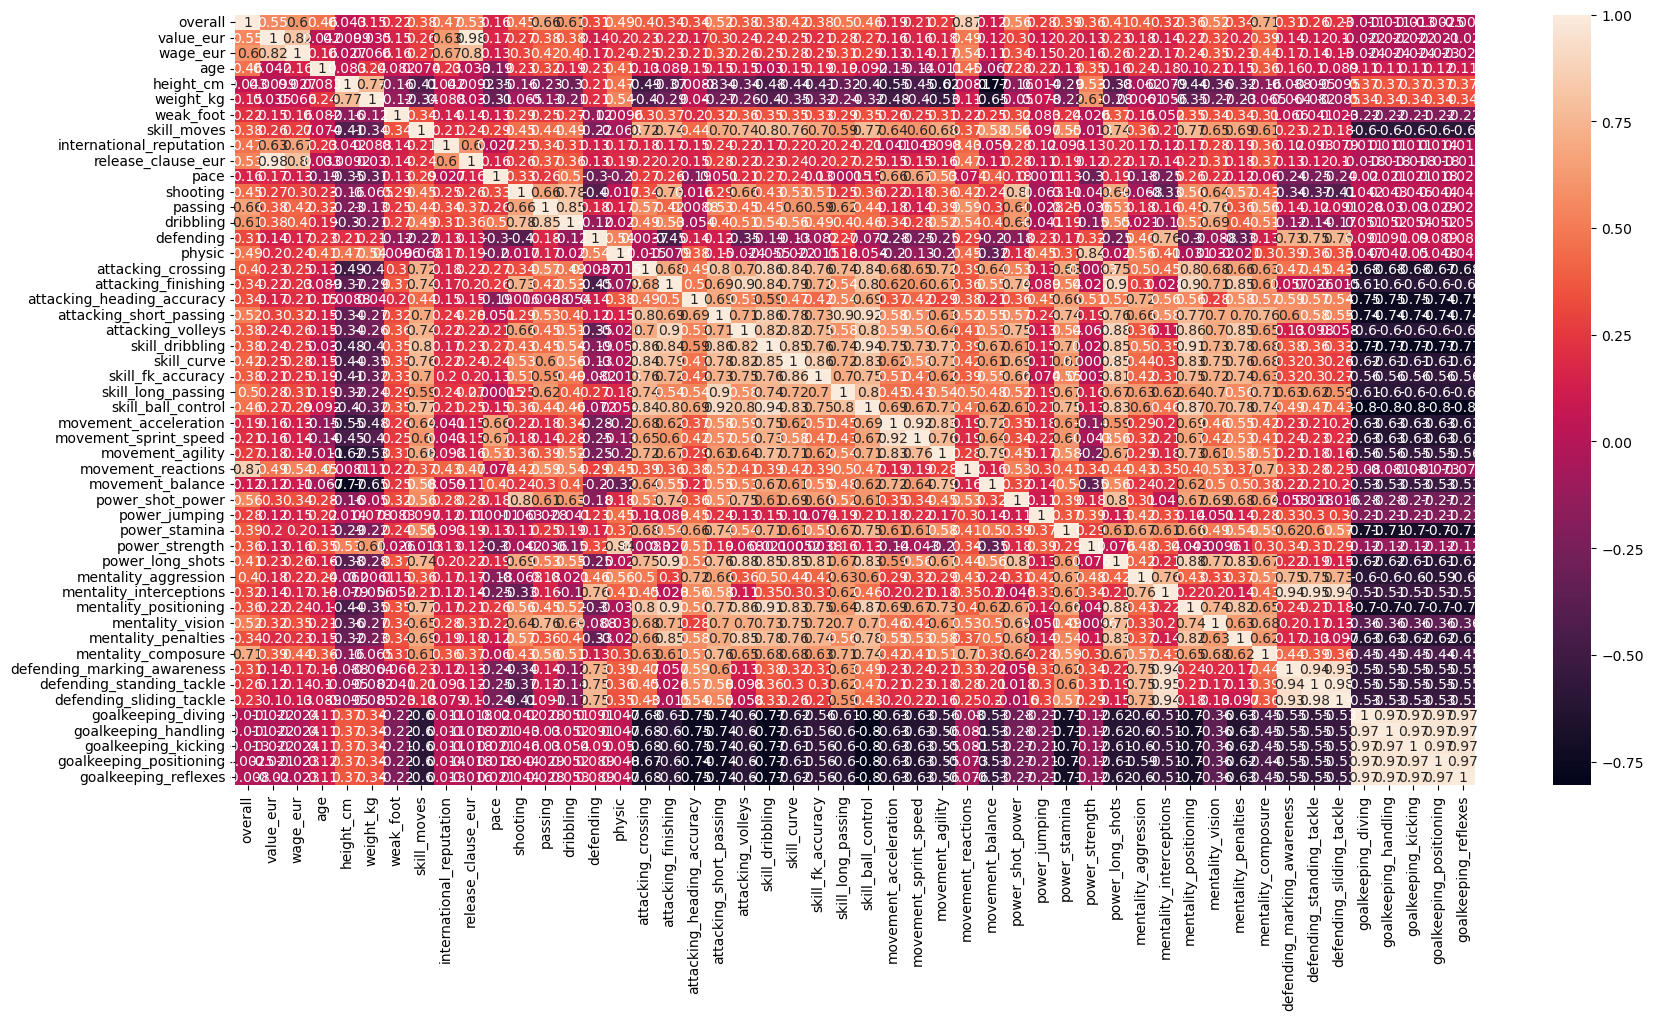

In [377]:
# Matriz de correlación
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c, annot=True)

In [378]:
### como se puede observar no hay nulos en las habilidades del jugador como portero, entonces se suman las 3 en un solo valor
df['goalkeeping1'] = df['goalkeeping_reflexes'] + df['goalkeeping_positioning']+df['goalkeeping_kicking']+ df['goalkeeping_handling']+df['goalkeeping_diving']
### igual a las habilidades del jugador como defensa 
df['defending1'] = df['defending_sliding_tackle']+df['defending_standing_tackle']+df['defending_marking_awareness']
### igual a las habilidaes del jugador como delantero 
df['attacking1'] = df['attacking_crossing']+ df['attacking_finishing']+df['attacking_heading_accuracy']+df['attacking_short_passing']+df['attacking_volleys']
# tambien haremos lo mismo con las skins, mentalidad, capacidad de movimiento, y capacidades fisicas
df['skills1'] = df['skill_ball_control']+ df['skill_long_passing']+df['skill_fk_accuracy']+df['skill_curve']+df['skill_dribbling']+df['skill_moves']
df['mentality1'] = df['mentality_composure']+ df['mentality_penalties']+df['mentality_vision']+df['mentality_positioning']+df['mentality_interceptions']+df['mentality_aggression']
df['movement1'] = df['movement_acceleration']+ df['movement_sprint_speed']+df['movement_agility']+df['movement_reactions']+df['movement_balance']
df['power'] = df['power_shot_power']+ df['power_jumping']+df['power_stamina']+df['power_strength']+df['power_long_shots']



In [379]:
df = df.drop(columns = ['goalkeeping_reflexes','goalkeeping_positioning','goalkeeping_kicking','goalkeeping_handling','goalkeeping_diving',
                        'defending_sliding_tackle','defending_standing_tackle','defending_marking_awareness',
                        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy','attacking_short_passing','attacking_volleys',
                        'skill_ball_control','skill_long_passing','skill_fk_accuracy','skill_curve','skill_dribbling','skill_moves',
                        'mentality_composure','mentality_penalties','mentality_vision','mentality_positioning','mentality_interceptions','mentality_aggression',
                        'movement_balance','movement_reactions','movement_agility','movement_sprint_speed','movement_acceleration',
                        'power_long_shots','power_strength','power_stamina','power_jumping','power_shot_power'])

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall                   19239 non-null  int64  
 1   value_eur                 19239 non-null  float64
 2   wage_eur                  19239 non-null  float64
 3   age                       19239 non-null  int64  
 4   height_cm                 19239 non-null  int64  
 5   weight_kg                 19239 non-null  int64  
 6   club_position             19239 non-null  object 
 7   preferred_foot            19239 non-null  object 
 8   weak_foot                 19239 non-null  int64  
 9   international_reputation  19239 non-null  int64  
 10  release_clause_eur        19239 non-null  float64
 11  pace                      19239 non-null  float64
 12  shooting                  19239 non-null  float64
 13  passing                   19239 non-null  float64
 14  dribbl

<Axes: >

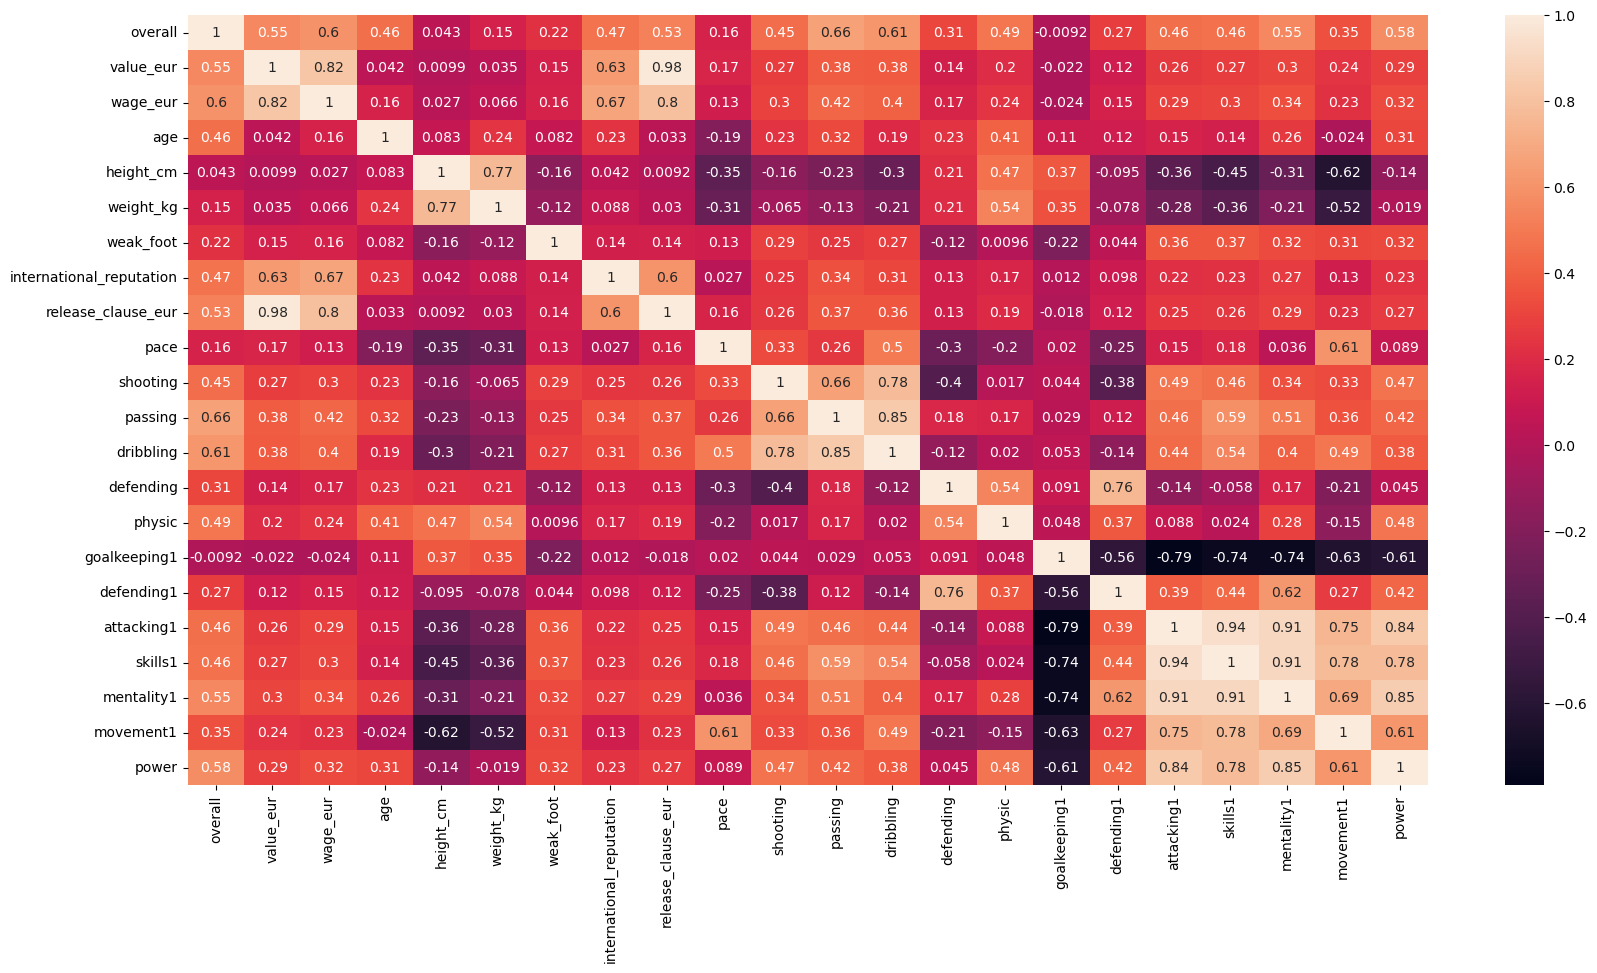

In [381]:
# Matriz de correlación
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c, annot=True)

In [382]:
# Eliminación de columna altamente correlacionada y con valores NaN
df.drop(['goalkeeping1'], axis=1, inplace=True)


In [383]:
### trasnformacion a binaria 
df['preferred_foot'] = df['preferred_foot'].replace({'Left': 1, 'Right': 0})

In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall                   19239 non-null  int64  
 1   value_eur                 19239 non-null  float64
 2   wage_eur                  19239 non-null  float64
 3   age                       19239 non-null  int64  
 4   height_cm                 19239 non-null  int64  
 5   weight_kg                 19239 non-null  int64  
 6   club_position             19239 non-null  object 
 7   preferred_foot            19239 non-null  int64  
 8   weak_foot                 19239 non-null  int64  
 9   international_reputation  19239 non-null  int64  
 10  release_clause_eur        19239 non-null  float64
 11  pace                      19239 non-null  float64
 12  shooting                  19239 non-null  float64
 13  passing                   19239 non-null  float64
 14  dribbl

#### Análisis exploratorio

In [384]:
df.describe().T

count          mean           std      min  \
overall                   19239.0  6.577218e+01  6.880232e+00     47.0   
value_eur                 19239.0  2.843238e+06  7.599929e+06   9000.0   
wage_eur                  19239.0  8.998908e+03  1.944223e+04    500.0   
age                       19239.0  2.521082e+01  4.748235e+00     16.0   
height_cm                 19239.0  1.812997e+02  6.863179e+00    155.0   
weight_kg                 19239.0  7.494303e+01  7.069434e+00     49.0   
preferred_foot            19239.0  2.372784e-01  4.254254e-01      0.0   
weak_foot                 19239.0  2.946151e+00  6.715605e-01      1.0   
international_reputation  19239.0  1.094184e+00  3.710982e-01      1.0   
release_clause_eur        19239.0  5.143353e+06  1.451247e+07  16000.0   
pace                      19239.0  6.830028e+01  1.031251e+01     28.0   
shooting                  19239.0  5.252867e+01  1.326033e+01     18.0   
passing                   19239.0  5.738874e+01  9.497105e+00     25.0   
dribbling                 19239.0  6.272062e+01  9.112023e+00     27.0   
defending                 19239.0  5.217974e+01  1.532578e+01     14.0   
physic                    19239.0  6.495369e+01  9.240764e+00     29.0   
defending1                19239.0  1.405540e+02  6.115369e+01     21.0   
attacking1                19239.0  2.485876e+02  7.468629e+01     39.0   
skills1                   19239.0  2.590751e+02  7.929836e+01     44.0   
mentality1                19239.0  3.122359e+02  7.508260e+01     63.0   
movement1                 19239.0  3.183865e+02  5.688352e+01    115.0   
power                     19239.0  2.973257e+02  5.150859e+01    132.0   

                               25%        50%        75%          max  
overall                       61.0       66.0       70.0         93.0  
value_eur                 475000.0   975000.0  2000000.0  194000000.0  
wage_eur                    1000.0     3000.0     8000.0     350000.0  
age                           21.0       25.0       29.0         54.0  
height_cm                    176.0      181.0      186.0        206.0  
weight_kg                     70.0       75.0       80.0        110.0  
preferred_foot                 0.0        0.0        0.0          1.0  
weak_foot                      3.0        3.0        3.0          5.0  
international_reputation       1.0        1.0        1.0          5.0  
release_clause_eur        845000.0  1600000.0  3400000.0  373500000.0  
pace                          63.0       69.0       75.0         97.0  
shooting                      44.0       54.0       62.0         94.0  
passing                       52.0       58.0       63.0         93.0  
dribbling                     58.0       64.0       68.0         95.0  
defending                     40.0       56.0       63.0         91.0  
physic                        60.0       66.0       71.0         90.0  
defending1                    84.0      160.0      191.0        270.0  
attacking1                   223.0      263.0      297.0        438.0  
skills1                      226.0      272.0      313.0        474.0  
mentality1                   280.0      322.0      362.0        501.0  
movement1                    291.0      328.0      357.0        462.0  
power                        265.0      303.0      335.0        436.0

In [385]:
#Cual es el comportamiento de la edad de los jugadores?
plt.figure(figsize = (8,5))
sns.histplot(data = df_1, x = 'age',bins = 10, kde = True, binwidth = 2);

NameError: name 'df_1' is not defined

<Figure size 800x500 with 0 Axes>

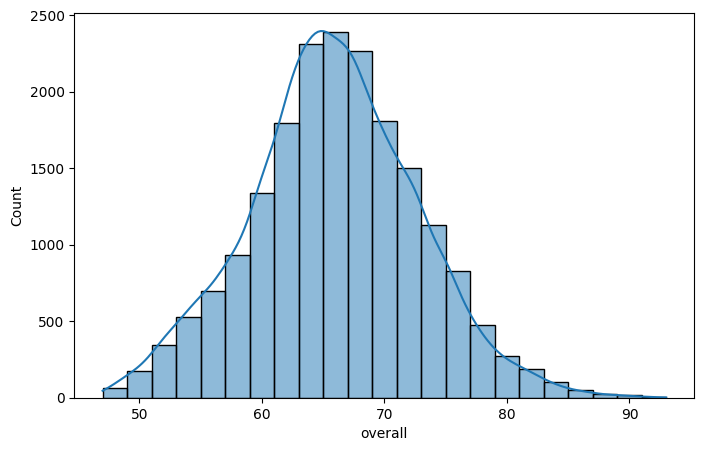

In [ ]:
#Cual es el comportamiento del puntaje (overall) de los jugadores?
plt.figure(figsize = (8,5))
sns.histplot(data = df_1, x = 'overall',bins = 10, kde = True, binwidth = 2);

In [ ]:
#Posiciones por jugador
df_1.player_positions.head()

0    RW, ST, CF
1            ST
2        ST, LW
3       LW, CAM
4       CM, CAM
Name: player_positions, dtype: object

In [ ]:
#Dejar solo una posicion para reducir la informacion 
df_1[['Posicion','posicion2','posicion3']] = df_1.player_positions.str.split(pat = ',', expand = True)
df_1 = df_1.drop(columns = ['player_positions','posicion2','posicion3'])
df_1.Posicion.head()

0    RW
1    ST
2    ST
3    LW
4    CM
Name: Posicion, dtype: object

In [ ]:
#Jugadores con mejor puntaje
Mejores_jugadores_por_posicion = df_1.loc[df_1.groupby(df_1['Posicion'])['overall'].idxmax()][['Posicion',
                                                                                     'short_name','overall']]
Mejores_jugadores_por_posicion

Posicion           short_name  overall
28       CAM      Bruno Fernandes       88
15        CB          V. van Dijk       89
10       CDM             N. Kanté       90
11        CF           K. Benzema       89
4         CM         K. De Bruyne       91
5         GK             J. Oblak       91
42        LB         A. Robertson       87
13        LM               H. Son       89
3         LW            Neymar Jr       91
165      LWB        L. Spinazzola       83
44        RB  T. Alexander-Arnold       87
45        RM            J. Sancho       87
0         RW             L. Messi       93
351      RWB          H. Hateboer       81
1         ST       R. Lewandowski       92

In [ ]:
#Cuantos jugadores hay por cada posicion?
pd.DataFrame(df_1.Posicion.value_counts()).T

Posicion    CB    ST    CM    GK   CDM    LB    RB   CAM    RM    LM   RW  \
count     3339  2608  2173  2132  1665  1360  1346  1151  1028  1016  495   

Posicion   LW  RWB  LWB   CF  
count     435  178  171  142

In [ ]:
#Clubes con mejor promedio de puntaje global - Overall
club_avg_overall = df_1.groupby('club_name')['overall'].mean().reset_index().sort_values('overall',ascending = False)
club_avg_overall.head().T

371                  473        361                244  \
club_name   Juventus  Paris Saint-Germain      Inter  FC Bayern München   
overall    79.961538            79.454545  78.857143          78.071429   

                         415  
club_name  Manchester United  
overall                 78.0

In [ ]:
#Decision: Dejar jugadores con Overall superior a 70 para reducir la base de datos
n = 10000

df_n = df_1.iloc[:n]
df_n = df_n[(df_n['overall']>70)]

# Aqui abajo creamos una variable llamada Posicion2, donde resuma las posiciones de los jugadores
# en tan solo 4 posiciones
Delantero = ['RF','ST','LW','LF','RS','LS','RM','LM','RW']
Mediocampista = ['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF']
Defensor = ['RCB','CB','LCB','LB','RB','RWB','LWB']
Arquero = ['GK']

def pos2(posicion):
    if posicion in Delantero:
        return 'Delantero'
    elif posicion in Mediocampista:
        return 'Mediocampista'
    elif posicion in Defensor:
        return 'Defensor'
    elif posicion in Arquero:
        return 'Arquero'
    
    else:
        return 'nan'
    
df_n['Posicion2'] = df_n['Posicion'].apply(lambda x: pos2(x))

NameError: name 'df_1' is not defined

In [ ]:
# Creamos un objeto con todas las skills
skills_ra = [ 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Skills de arquero:
skills_gk = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','Posicion2']

# Skills de defensor:
skills_def = [ 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle','Posicion2']
# Skills de atacantes:
skills_at = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'Posicion2']

# Skills de mediocampo:
skills_mid = ['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'Posicion2']

# Skills de Movimiento y balance
skills_movement = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'Posicion2']
# Skills de Fuerza
skills_power = ['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'Posicion2']

# Skills Mentales
skills_mental = ['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'Posicion2']


print(len(skills_ra), 'Variables numericas de desempeño segun habilidades')

40 Variables numericas de desempeño segun habilidades


In [ ]:
posiciones=df_n.loc[:, 'Posicion2']

In [ ]:
posiciones.value_counts()

Posicion2
Defensor         1485
Delantero        1332
Mediocampista    1332
Arquero           444
Name: count, dtype: int64

In [ ]:
df_n.shape

(4593, 90)

In [ ]:
#Revisar nulos 
null_counts = df_n.isnull().sum()
null_columns = null_counts[null_counts > 0]  # Filtrar las columnas con valores nulos

# Mostrar solo las columnas con valores nulos
print(null_columns)

value_eur                     28
wage_eur                      25
club_team_id                  25
club_name                     25
league_name                   25
league_level                  25
club_jersey_number            25
club_joined                  315
club_contract_valid_until     25
release_clause_eur           318
pace                         444
shooting                     444
passing                      444
dribbling                    444
defending                    444
physic                       444
dtype: int64


In [ ]:
columns_to_fill = ['value_eur', 'wage_eur', 'club_team_id', 'club_jersey_number', 'release_clause_eur', 
                   'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

# Calcular la mediana de las columnas seleccionadas
medians = df_n[columns_to_fill].median()

# Reemplazar los valores nulos en las columnas seleccionadas con la mediana
df_n[columns_to_fill] = df_n[columns_to_fill].fillna(medians)

In [ ]:
columns_to_fill = ['club_name', 'league_name', 'league_level', 'club_joined', 'club_contract_valid_until']

for column in columns_to_fill:
    mode_value = df_n[column].mode()[0]  # Calcula la moda de la columna
    df_n[column].fillna(mode_value, inplace=True)  # Reemplaza los valores nulos con la moda

# Verifica que los valores nulos se hayan reemplazado correctamente
df_n.isnull().sum()

short_name                     0
overall                        0
potential                      0
value_eur                      0
wage_eur                       0
age                            0
dob                            0
height_cm                      0
weight_kg                      0
club_team_id                   0
club_name                      0
league_name                    0
league_level                   0
club_jersey_number             0
club_joined                    0
club_contract_valid_until      0
nationality_name               0
preferred_foot                 0
weak_foot                      0
skill_moves                    0
international_reputation       0
work_rate                      0
release_clause_eur             0
pace                           0
shooting                       0
passing                        0
dribbling                      0
defending                      0
physic                         0
attacking_crossing             0
attacking_

In [ ]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4593 entries, 0 to 4592
Data columns (total 90 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   short_name                   4593 non-null   object 
 1   overall                      4593 non-null   int64  
 2   potential                    4593 non-null   int64  
 3   value_eur                    4593 non-null   float64
 4   wage_eur                     4593 non-null   float64
 5   age                          4593 non-null   int64  
 6   dob                          4593 non-null   object 
 7   height_cm                    4593 non-null   int64  
 8   weight_kg                    4593 non-null   int64  
 9   club_team_id                 4593 non-null   float64
 10  club_name                    4593 non-null   object 
 11  league_name                  4593 non-null   object 
 12  league_level                 4593 non-null   float64
 13  club_jersey_number     

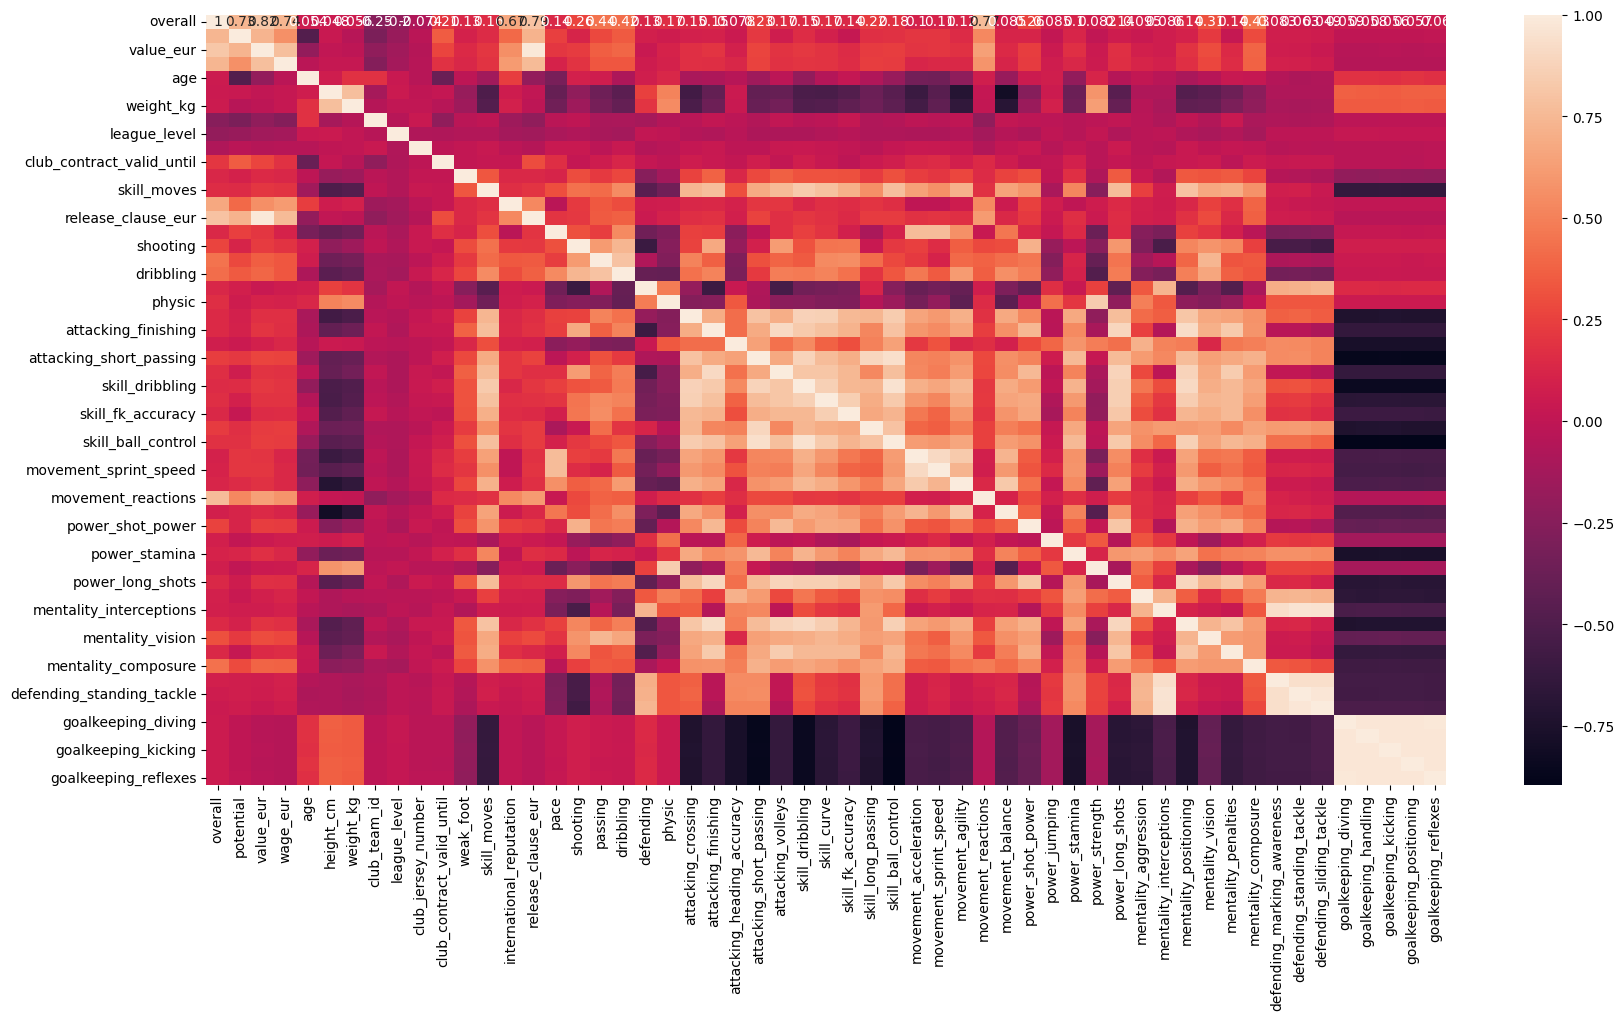

In [ ]:
# Matriz de correlación
# Seleccionar solo las columnas numéricas
df_numeric = df_n.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

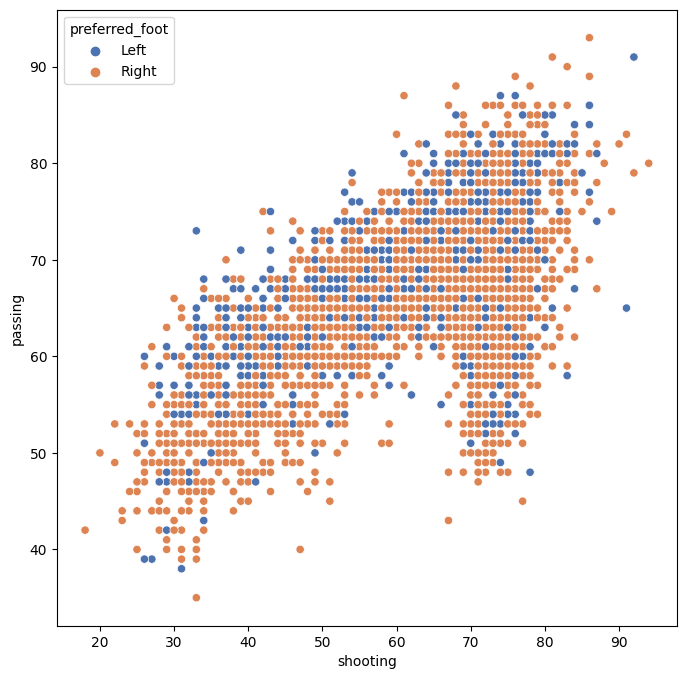

In [ ]:
# Aqui comparamos dos habilidades (disparo al arco y pase), y a su vez creamos dos colores para diferenciar los jugadores que son derechos (naranjas) y los jugadores que son zurdos (azules)
plt.figure(figsize = (8,8))
sns.scatterplot(data = df_n, x = 'shooting', y = 'passing', hue = 'preferred_foot', palette = 'deep');

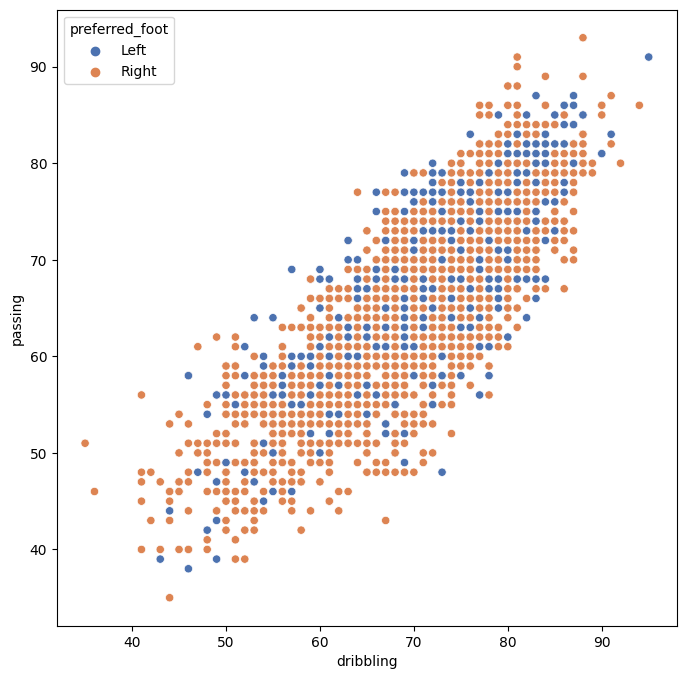

In [ ]:
# Aqui comparamos dos habilidades (dribbling y pase), y a su vez creamos dos colores para diferenciar los jugadores que son derechos (naranjas) y los jugadores que son zurdos (azules)
plt.figure(figsize = (8,8))
sns.scatterplot(data = df_n, x = 'dribbling', y = 'passing', hue = 'preferred_foot', palette = 'deep');

### Procedemos a crear al jugador perfecto, y al jugador promedio:

In [ ]:
MachineGunDict = {'short_name':'MachineGun','overall':99}
for skills in skills_ra:
    MachineGunDict [skills] = 99
    
df_n =  pd.concat([df_n, pd.DataFrame(MachineGunDict, index=[0])])

JugadorPromedioDict = {'short_name':'Promedio','overall':df_n.overall.mean()}
for skills in skills_ra:
    JugadorPromedioDict [skills] = df_n[skills].mean()
    
df_n = pd.concat([df_n, pd.DataFrame(JugadorPromedioDict, index=[1])])

In [ ]:
df_skills = df_n[skills_ra+ ['Posicion2']]

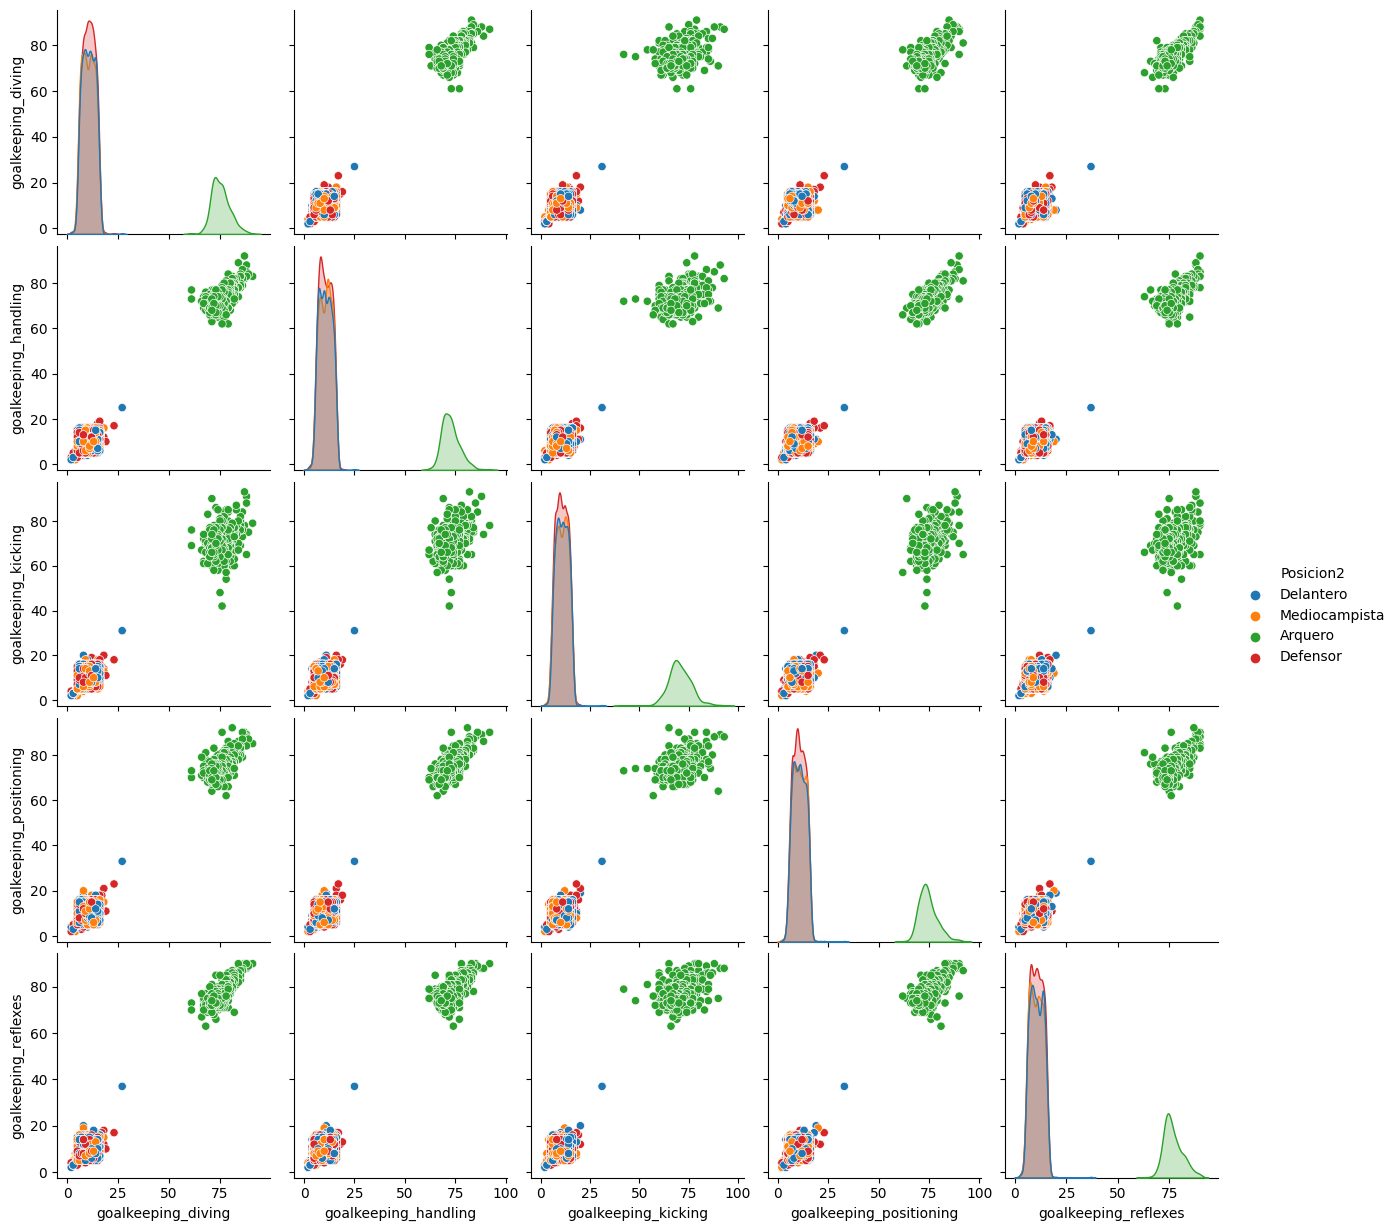

In [ ]:
sns.pairplot(df_skills[skills_gk], hue = 'Posicion2');

## CLUSTERINGs

### Clustering con KMeans

In [ ]:
df2 = df_skills.copy()
df2 = df2.drop(columns = 'Posicion2')
imputer = SimpleImputer (missing_values = np.nan, strategy = 'most_frequent')
df2 = pd.DataFrame ( imputer.fit_transform(df2), columns = df2.columns, index = df2.index)

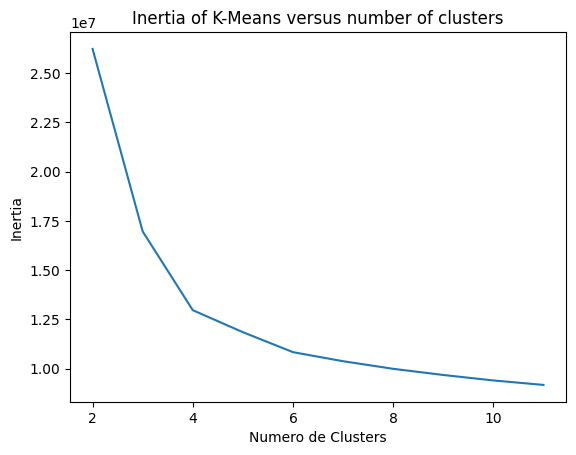

In [ ]:
scores = [KMeans (n_clusters = i).fit(df2).inertia_ for i in range (2,12)]

plt.plot(np.arange(2,12), scores);
plt.xlabel('Numero de Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of K-Means versus number of clusters');
## Se seleccionan cuatro clusters

In [ ]:
n_clust = 4

km = KMeans(n_clusters = n_clust)
km.fit(df2)

clusters = km.labels_

In [ ]:
df_clust = df2.copy()
df_clust['kmeans4'] = km.labels_

print('KMeans encontro: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clust

KMeans encontro:  4 clusters, nosotros forzamos la cantidad


pace   shooting    passing  dribbling  defending     physic  \
0     85.000000  92.000000  91.000000  95.000000  34.000000  65.000000   
1     78.000000  92.000000  79.000000  86.000000  44.000000  82.000000   
2     87.000000  94.000000  80.000000  88.000000  34.000000  75.000000   
3     91.000000  83.000000  86.000000  94.000000  37.000000  63.000000   
4     76.000000  86.000000  93.000000  88.000000  64.000000  78.000000   
...         ...        ...        ...        ...        ...        ...   
4590  81.000000  51.000000  66.000000  70.000000  66.000000  67.000000   
4591  76.000000  70.000000  60.000000  65.000000  39.000000  71.000000   
4592  61.000000  62.000000  67.000000  71.000000  65.000000  73.000000   
0     99.000000  99.000000  99.000000  99.000000  99.000000  99.000000   
1     70.881149  61.853722  66.859382  71.080322  59.648455  70.889639   

      attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0              85.000000            95.000000                   70.000000   
1              71.000000            95.000000                   90.000000   
2              87.000000            95.000000                   90.000000   
3              85.000000            83.000000                   63.000000   
4              94.000000            82.000000                   55.000000   
...                  ...                  ...                         ...   
4590           70.000000            61.000000                   49.000000   
4591           64.000000            74.000000                   72.000000   
4592           57.000000            61.000000                   54.000000   
0              99.000000            99.000000                   99.000000   
1              58.547889            54.389421                   58.903788   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                   91.000000          88.000000        96.000000   
1                   85.000000          89.000000        85.000000   
2                   80.000000          86.000000        88.000000   
3                   86.000000          86.000000        95.000000   
4                   94.000000          82.000000        88.000000   
...                       ...                ...              ...   
4590                71.000000          29.000000        71.000000   
4591                63.000000          58.000000        66.000000   
4592                70.000000          61.000000        71.000000   
0                   99.000000          99.000000        99.000000   
1                   68.211363          51.399869        64.762299   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0       93.000000          94.000000            91.00000           96.000000   
1       79.000000          85.000000            70.00000           88.000000   
2       81.000000          84.000000            77.00000           88.000000   
3       88.000000          87.000000            81.00000           95.000000   
4       85.000000          83.000000            93.00000           91.000000   
...           ...                ...                 ...                 ...   
4590    74.000000          35.000000            69.00000           72.000000   
4591    56.000000          49.000000            57.00000           65.000000   
4592    60.000000          49.000000            74.00000           78.000000   
0       99.000000          99.000000            99.00000           99.000000   
1       57.437527          50.704615            62.67044           67.875054   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                 91.000000              80.000000          91.00000   
1                 77.000000              79.000000          77.00000   
2                 85.000000              88.000000          86.00000   
3                 93.000000              89.000000          96.00000   
4                 76.000000              76.000

### Clustering Mean Shift

In [ ]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
from sklearn.cluster import estimate_bandwidth
bw=estimate_bandwidth(df2, quantile=0.09, n_samples=None, random_state=0, n_jobs=None)

ms = MeanShift(bandwidth= bw)

ms.fit(df2)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 5


In [ ]:
df2['ms_labels'] = ms.labels_

In [ ]:
# Cantidad de observaciones por cluster
df2.ms_labels.value_counts()

ms_labels
0    2584
1    1566
2     443
4       1
3       1
Name: count, dtype: int64

In [ ]:
df2.head()

pace  shooting  passing  dribbling  defending  physic  attacking_crossing  \
0  85.0      92.0     91.0       95.0       34.0    65.0                85.0   
1  78.0      92.0     79.0       86.0       44.0    82.0                71.0   
2  87.0      94.0     80.0       88.0       34.0    75.0                87.0   
3  91.0      83.0     86.0       94.0       37.0    63.0                85.0   
4  76.0      86.0     93.0       88.0       64.0    78.0                94.0   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
0                 95.0                        70.0                     91.0   
1                 95.0                        90.0                     85.0   
2                 95.0                        90.0                     80.0   
3                 83.0                        63.0                     86.0   
4                 82.0                        55.0                     94.0   

   attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  \
0               88.0             96.0         93.0               94.0   
1               89.0             85.0         79.0               85.0   
2               86.0             88.0         81.0               84.0   
3               86.0             95.0         88.0               87.0   
4               82.0             88.0         85.0               83.0   

   skill_long_passing  skill_ball_control  movement_acceleration  \
0                91.0                96.0                   91.0   
1                70.0                88.0                   77.0   
2                77.0                88.0                   85.0   
3                81.0                95.0                   93.0   
4                93.0                91.0                   76.0   

   movement_sprint_speed  movement_agility  movement_reactions  \
0                   80.0              91.0                94.0   
1                   79.0              77.0                93.0   
2                   88.0              86.0                94.0   
3                   89.0              96.0                89.0   
4                   76.0              79.0                91.0   

   movement_balance  power_shot_power  power_jumping  power_stamina  \
0              95.0              86.0           68.0           72.0   
1              82.0              90.0           85.0           76.0   
2              74.0              94.0           95.0           77.0   
3              84.0              80.0           64.0           81.0   
4              78.0              91.0           63.0           89.0   

   power_strength  power_long_shots  mentality_aggression  \
0            69.0              94.0                  44.0   
1            86.0              87.0                  81.0   
2            77.0              93.0                  63.0   
3            53.0              81.0                  63.0   
4            74.0              91.0                  76.0   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                     40.0                   93.0              95.0   
1                     49.0                   95.0              81.0   
2                     29.0                   95.0              76.0   
3                     37.0                   86.0              90.0   
4                     66.0                   88.0              94.0   

   mentality_penalties  mentality_composure  defending_marking_awareness  \
0                 75.0                 96.0                         20.0   
1                 90.0                 88.0                         35.0   
2                 88.0                 95.0                         24.0   
3                 93.0                 93.0                         35.0   
4                 83.0                 89.0                         68.0   

   defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                       35.0                  

In [ ]:
# Análisis descriptivo, separando por cluster
# Creamos un objeto con todas las skills
skills_ra = [ 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Skills de arquero:
skills_gk = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','ms_labels']

# Skills de defensor:
skills_def = [ 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle','ms_labels']
# Skills de atacantes:
skills_at = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'ms_labels']

# Skills de mediocampo:
skills_mid = ['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'ms_labels']

# Skills de Movimiento y balance
skills_movement = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'ms_labels']

# Skills de Fuerza
skills_power = ['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'ms_labels']

# Skills Mentales
skills_mental = ['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'ms_labels']

#### GRÁFICOS

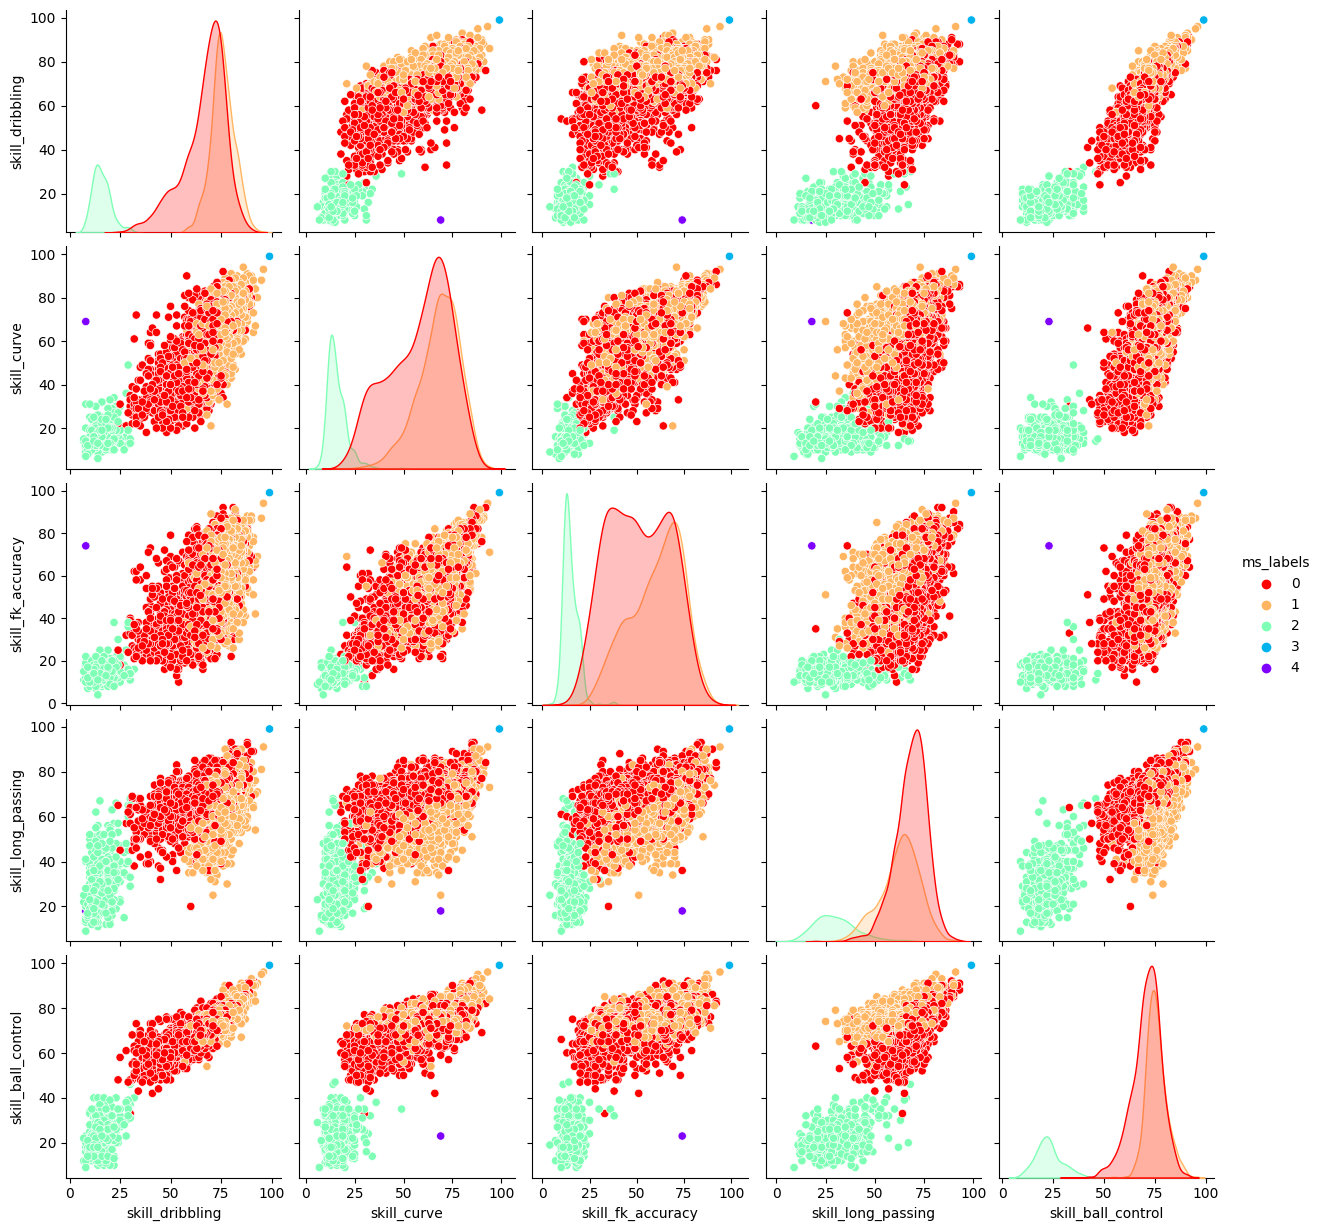

In [ ]:
sns.pairplot(df2[skills_mid],hue ='ms_labels' ,palette = 'rainbow_r');

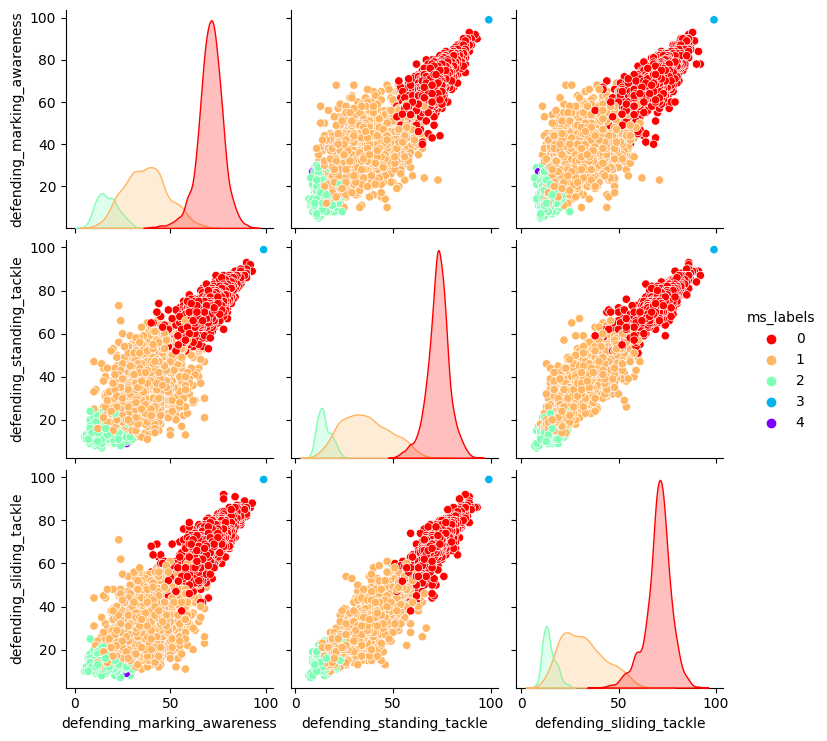

In [ ]:
sns.pairplot(df2[skills_def],hue ='ms_labels' ,palette = 'rainbow_r');

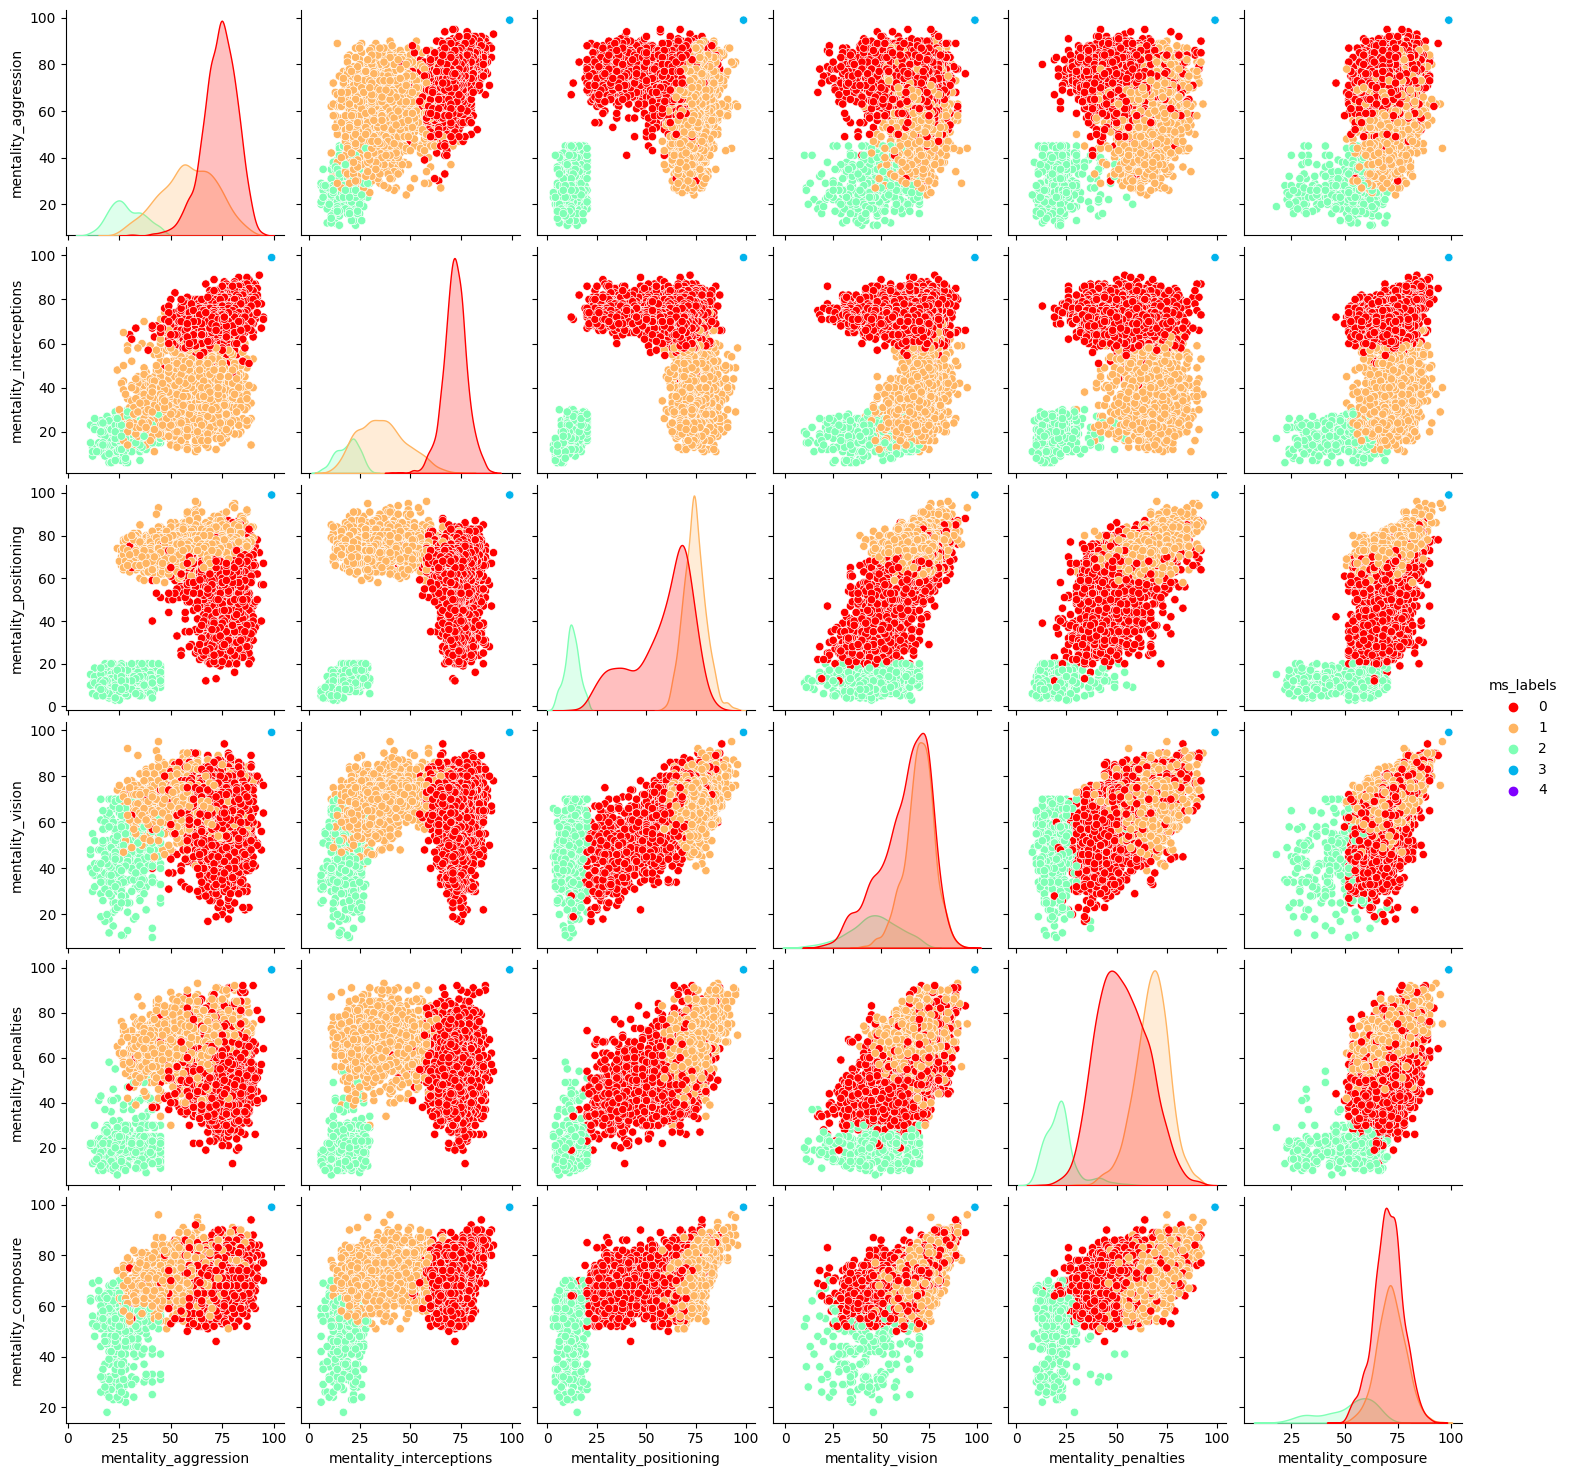

In [ ]:
sns.pairplot(df2[skills_mental],hue ='ms_labels' ,palette = 'rainbow_r');

#### ANÁLISIS

In [ ]:
df3 = df2.merge(posiciones, left_index=True, right_index=True, how='left')
df3.head(3)

pace  shooting  passing  dribbling  defending  physic  attacking_crossing  \
0  85.0      92.0     91.0       95.0       34.0    65.0                85.0   
0  99.0      99.0     99.0       99.0       99.0    99.0                99.0   
1  78.0      92.0     79.0       86.0       44.0    82.0                71.0   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
0                 95.0                        70.0                     91.0   
0                 99.0                        99.0                     99.0   
1                 95.0                        90.0                     85.0   

   attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  \
0               88.0             96.0         93.0               94.0   
0               99.0             99.0         99.0               99.0   
1               89.0             85.0         79.0               85.0   

   skill_long_passing  skill_ball_control  movement_acceleration  \
0                91.0                96.0                   91.0   
0                99.0                99.0                   99.0   
1                70.0                88.0                   77.0   

   movement_sprint_speed  movement_agility  movement_reactions  \
0                   80.0              91.0                94.0   
0                   99.0              99.0                99.0   
1                   79.0              77.0                93.0   

   movement_balance  power_shot_power  power_jumping  power_stamina  \
0              95.0              86.0           68.0           72.0   
0              99.0              99.0           99.0           99.0   
1              82.0              90.0           85.0           76.0   

   power_strength  power_long_shots  mentality_aggression  \
0            69.0              94.0                  44.0   
0            99.0              99.0                  99.0   
1            86.0              87.0                  81.0   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                     40.0                   93.0              95.0   
0                     99.0                   99.0              99.0   
1                     49.0                   95.0              81.0   

   mentality_penalties  mentality_composure  defending_marking_awareness  \
0                 75.0                 96.0                         20.0   
0                 99.0                 99.0                         99.0   
1                 90.0                 88.0                         35.0   

   defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                       35.0                      24.0                 6.0   
0                       99.0                      99.0                99.0   
1                       42.0                      19.0                15.0   

   goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
0                  11.0                 15.0                     14.0   
0                  99.0                 99.0                     99.0   
1                   6.0                 12.0                      8.0   

   goalkeeping_reflexes  ms_labels  Posicion2  
0                   8.0          1  Delantero  
0                  99.0          3  Delantero  
1                  10.0          1  Delantero

In [ ]:
data_crosstab = pd.crosstab(df3['ms_labels'],
                            df3['Posicion2'], 
                               margins = False)
print(data_crosstab)

Posicion2  Arquero  Defensor  Delantero  Mediocampista
ms_labels                                             
0                0      1485        105            994
1                0         0       1228            338
2              443         0          0              0
3                0         0          1              0
4                1         0          0              0


**Lectura del anterior resultado.**
- La categoria 0 agrupa a todos los defensores, a unos pocos delanteros y a muchos mediocampistas
- La categoria 1 agrupa a casi todos los delanteros y a una parte de los mediocampistas
- Otra categoria es para todos los arqueros y la categoría 4 es para un arquero de muy bajo rendimiento

### Clustering con KMeans | Eliminando arqueros

In [ ]:
## CLUSTERING K MEDIAS PERO ELIMINANDO A LOS ARQUEROS DE LA BASE##
df_skills=df_skills.loc[df_skills.Posicion2!="Arquero"]
df4 = df_skills.copy()
df4 = df4.drop(columns = 'Posicion2')
imputer = SimpleImputer (missing_values = np.nan, strategy = 'most_frequent')
df4 = pd.DataFrame ( imputer.fit_transform(df4), columns = df4.columns, index = df4.index)

In [ ]:
df4.shape

(4151, 40)

In [ ]:
posiciones2=df_skills.loc[:,['Posicion2']]
posiciones2.shape

(4151, 1)

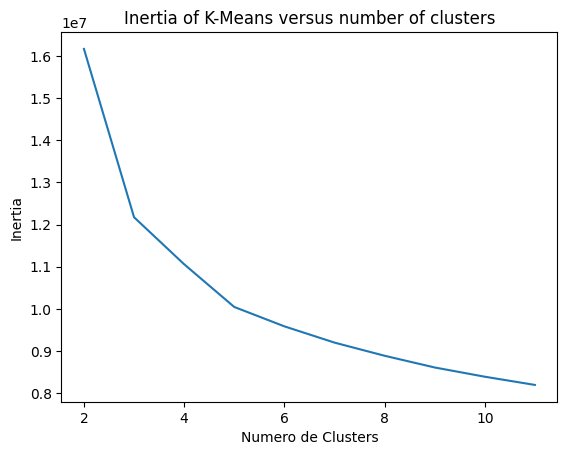

In [ ]:
scores = [KMeans (n_clusters = i).fit(df4).inertia_ for i in range (2,12)]

plt.plot(np.arange(2,12), scores);
plt.xlabel('Numero de Clusters')
plt.ylabel('Inertia')
plt.title('Inertia of K-Means versus number of clusters');
## Se seleccionan 3 clusters

In [ ]:
n_clust = 3

km = KMeans(n_clusters = n_clust)
km.fit(df4)

clusters = km.labels_

In [ ]:
df_clust2 = df4.copy()
df_clust2['kmeans4'] = km.labels_

print('KMeans encontro: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')
df_clust2

KMeans encontro:  3 clusters, nosotros forzamos la cantidad


pace   shooting    passing  dribbling  defending     physic  \
0     85.000000  92.000000  91.000000  95.000000  34.000000  65.000000   
1     78.000000  92.000000  79.000000  86.000000  44.000000  82.000000   
2     87.000000  94.000000  80.000000  88.000000  34.000000  75.000000   
3     91.000000  83.000000  86.000000  94.000000  37.000000  63.000000   
4     76.000000  86.000000  93.000000  88.000000  64.000000  78.000000   
...         ...        ...        ...        ...        ...        ...   
4590  81.000000  51.000000  66.000000  70.000000  66.000000  67.000000   
4591  76.000000  70.000000  60.000000  65.000000  39.000000  71.000000   
4592  61.000000  62.000000  67.000000  71.000000  65.000000  73.000000   
0     99.000000  99.000000  99.000000  99.000000  99.000000  99.000000   
1     70.881149  61.853722  66.859382  71.080322  59.648455  70.889639   

      attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0              85.000000            95.000000                   70.000000   
1              71.000000            95.000000                   90.000000   
2              87.000000            95.000000                   90.000000   
3              85.000000            83.000000                   63.000000   
4              94.000000            82.000000                   55.000000   
...                  ...                  ...                         ...   
4590           70.000000            61.000000                   49.000000   
4591           64.000000            74.000000                   72.000000   
4592           57.000000            61.000000                   54.000000   
0              99.000000            99.000000                   99.000000   
1              58.547889            54.389421                   58.903788   

      attacking_short_passing  attacking_volleys  skill_dribbling  \
0                   91.000000          88.000000        96.000000   
1                   85.000000          89.000000        85.000000   
2                   80.000000          86.000000        88.000000   
3                   86.000000          86.000000        95.000000   
4                   94.000000          82.000000        88.000000   
...                       ...                ...              ...   
4590                71.000000          29.000000        71.000000   
4591                63.000000          58.000000        66.000000   
4592                70.000000          61.000000        71.000000   
0                   99.000000          99.000000        99.000000   
1                   68.211363          51.399869        64.762299   

      skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0       93.000000          94.000000            91.00000           96.000000   
1       79.000000          85.000000            70.00000           88.000000   
2       81.000000          84.000000            77.00000           88.000000   
3       88.000000          87.000000            81.00000           95.000000   
4       85.000000          83.000000            93.00000           91.000000   
...           ...                ...                 ...                 ...   
4590    74.000000          35.000000            69.00000           72.000000   
4591    56.000000          49.000000            57.00000           65.000000   
4592    60.000000          49.000000            74.00000           78.000000   
0       99.000000          99.000000            99.00000           99.000000   
1       57.437527          50.704615            62.67044           67.875054   

      movement_acceleration  movement_sprint_speed  movement_agility  \
0                 91.000000              80.000000          91.00000   
1                 77.000000              79.000000          77.00000   
2                 85.000000              88.000000          86.00000   
3                 93.000000              89.000000          96.00000   
4                 76.000000              76.000

In [ ]:
# Creamos un objeto con todas las skills
skills_ra = [ 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Skills de arquero:
skills_gk = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','kmeans4']

# Skills de defensor:
skills_def = [ 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle','kmeans4']
# Skills de atacantes:
skills_at = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'kmeans4']

# Skills de mediocampo:
skills_mid = ['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'kmeans4']

# Skills de Movimiento y balance
skills_movement = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'kmeans4']

# Skills de Fuerza
skills_power = ['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'kmeans4']

# Skills Mentales
skills_mental = ['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'kmeans4']

#### GRÁFICOS

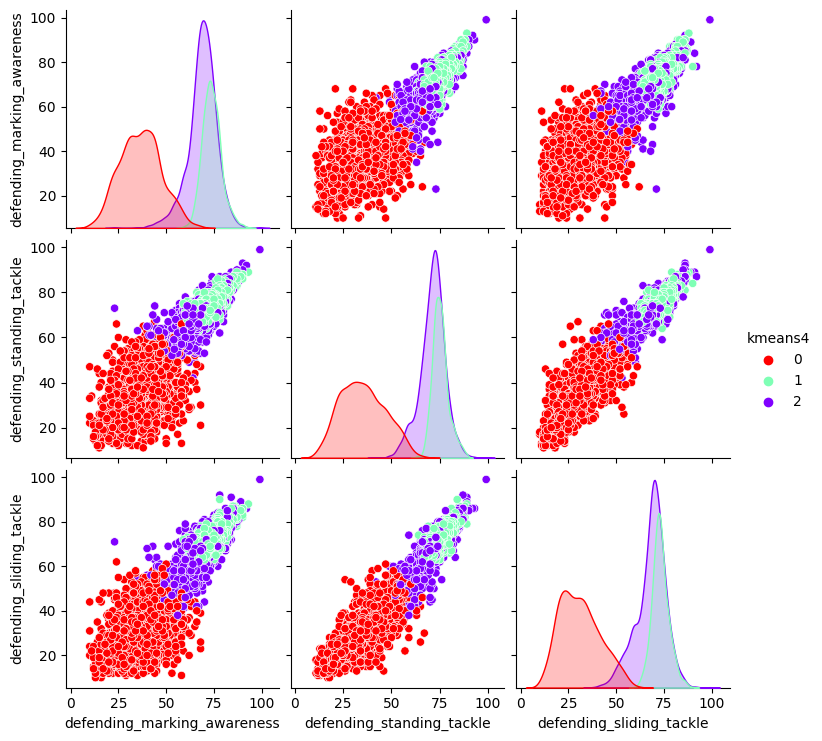

In [ ]:
## Graficamos las skills de defensor contra los 3 clusters estimados#
sns.pairplot(df_clust2[skills_def], hue ='kmeans4', palette = 'rainbow_r');

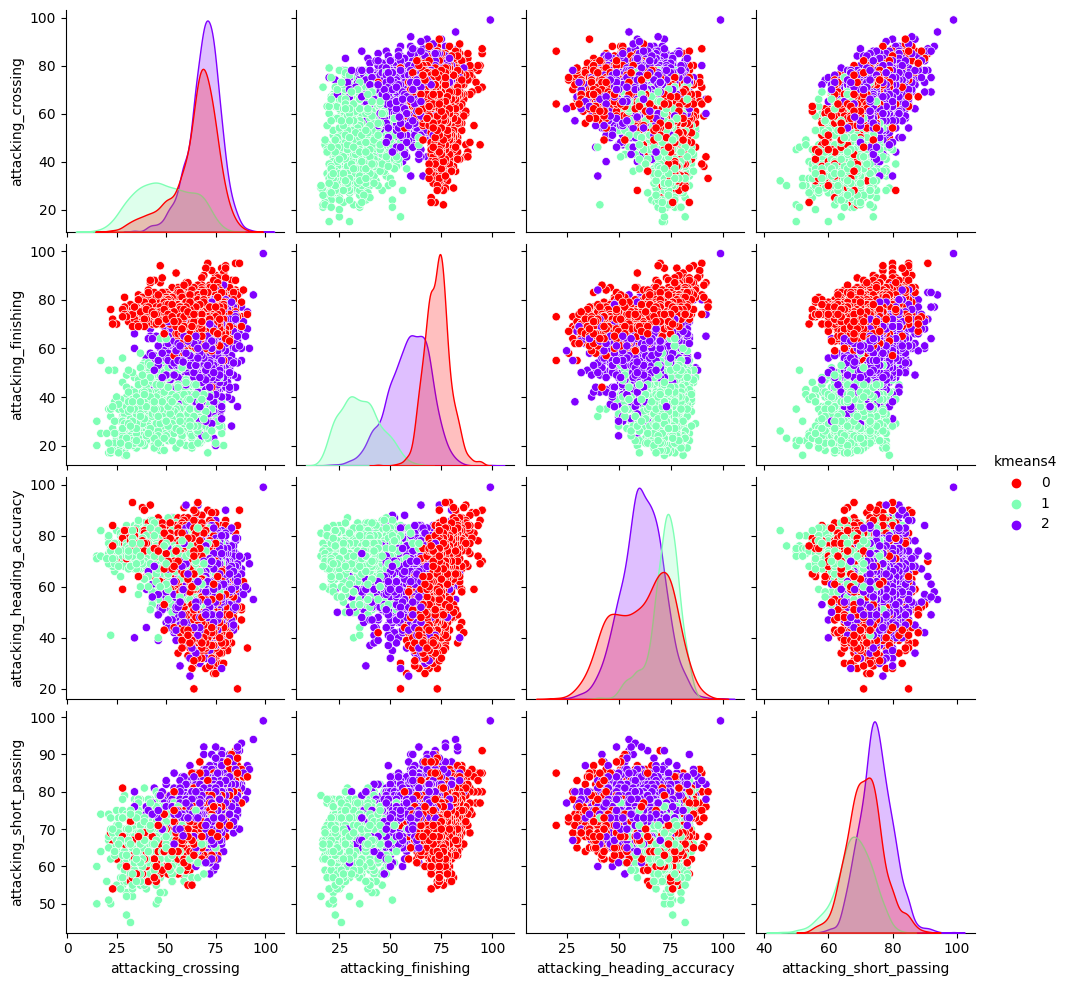

In [ ]:
## Graficamos las skills de atacante contra los 3 clusters estimados#
sns.pairplot(df_clust2[skills_at], hue ='kmeans4', palette = 'rainbow_r');

#### ANÁLISIS

In [ ]:
df5 = df_clust2.merge(posiciones2, left_index=True, right_index=True, how='left')
df5.head()

pace  shooting  passing  dribbling  defending  physic  attacking_crossing  \
0  85.0      92.0     91.0       95.0       34.0    65.0                85.0   
0  85.0      92.0     91.0       95.0       34.0    65.0                85.0   
0  99.0      99.0     99.0       99.0       99.0    99.0                99.0   
0  99.0      99.0     99.0       99.0       99.0    99.0                99.0   
1  78.0      92.0     79.0       86.0       44.0    82.0                71.0   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
0                 95.0                        70.0                     91.0   
0                 95.0                        70.0                     91.0   
0                 99.0                        99.0                     99.0   
0                 99.0                        99.0                     99.0   
1                 95.0                        90.0                     85.0   

   attacking_volleys  skill_dribbling  skill_curve  skill_fk_accuracy  \
0               88.0             96.0         93.0               94.0   
0               88.0             96.0         93.0               94.0   
0               99.0             99.0         99.0               99.0   
0               99.0             99.0         99.0               99.0   
1               89.0             85.0         79.0               85.0   

   skill_long_passing  skill_ball_control  movement_acceleration  \
0                91.0                96.0                   91.0   
0                91.0                96.0                   91.0   
0                99.0                99.0                   99.0   
0                99.0                99.0                   99.0   
1                70.0                88.0                   77.0   

   movement_sprint_speed  movement_agility  movement_reactions  \
0                   80.0              91.0                94.0   
0                   80.0              91.0                94.0   
0                   99.0              99.0                99.0   
0                   99.0              99.0                99.0   
1                   79.0              77.0                93.0   

   movement_balance  power_shot_power  power_jumping  power_stamina  \
0              95.0              86.0           68.0           72.0   
0              95.0              86.0           68.0           72.0   
0              99.0              99.0           99.0           99.0   
0              99.0              99.0           99.0           99.0   
1              82.0              90.0           85.0           76.0   

   power_strength  power_long_shots  mentality_aggression  \
0            69.0              94.0                  44.0   
0            69.0              94.0                  44.0   
0            99.0              99.0                  99.0   
0            99.0              99.0                  99.0   
1            86.0              87.0                  81.0   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                     40.0                   93.0              95.0   
0                     40.0                   93.0              95.0   
0                     99.0                   99.0              99.0   
0                     99.0                   99.0              99.0   
1                     49.0                   95.0              81.0   

   mentality_penalties  mentality_composure  defending_marking_awareness  \
0                 75.0                 96.0                         20.0   
0                 75.0                 96.0                         20.0   
0                 99.0                 99.0                         99.0   
0                 99.0                 99.0                         99.0   
1                 90.0                 88.0                         35.0   

   defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                       35.0                  

In [ ]:
data_crosstab = pd.crosstab(df5['kmeans4'],
                            df5['Posicion2'], 
                               margins = False)
print(data_crosstab)

Posicion2  Defensor  Delantero  Mediocampista
kmeans4                                      
0                 0       1202            299
1               825          0             98
2               660        132            935


**Lectura del anterior resutado**
- La categoria cero contine más delanteros, y no toma defensores
- La categoría uno, en su mayoria son defensores, y no cuenta con delanteros
- La categoría dos, es la que más jugadores tomó, en su mayoria son mediocampitas, segidos de defensores con muy poca diferencia.

### Clustering Mean Shift | Eliminando arqueros

In [ ]:
del df_clust2['kmeans4']

In [ ]:
bw=estimate_bandwidth(df_clust2, quantile=0.09, n_samples=None, random_state=0, n_jobs=None)

ms = MeanShift(bandwidth= bw)

ms.fit(df_clust2)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 5


In [ ]:
df_clust2['ms_labels'] = ms.labels_

In [ ]:
# Cantidad de observaciones por cluster
df_clust2.ms_labels.value_counts()

ms_labels
0    2071
1    1555
3     408
4     116
2       1
Name: count, dtype: int64

In [ ]:
# Análisis descriptivo, separando por cluster
# Creamos un objeto con todas las skills
skills_ra = [ 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Skills de arquero:
skills_gk = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes','ms_labels']

# Skills de defensor:
skills_def = [ 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle','ms_labels']
# Skills de atacantes:
skills_at = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing', 'ms_labels']

# Skills de mediocampo:
skills_mid = ['skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'ms_labels']

# Skills de Movimiento y balance
skills_movement = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'ms_labels']

# Skills de Fuerza
skills_power = ['power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'ms_labels']

# Skills Mentales
skills_mental = ['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'ms_labels']

#### GRÁFICOS

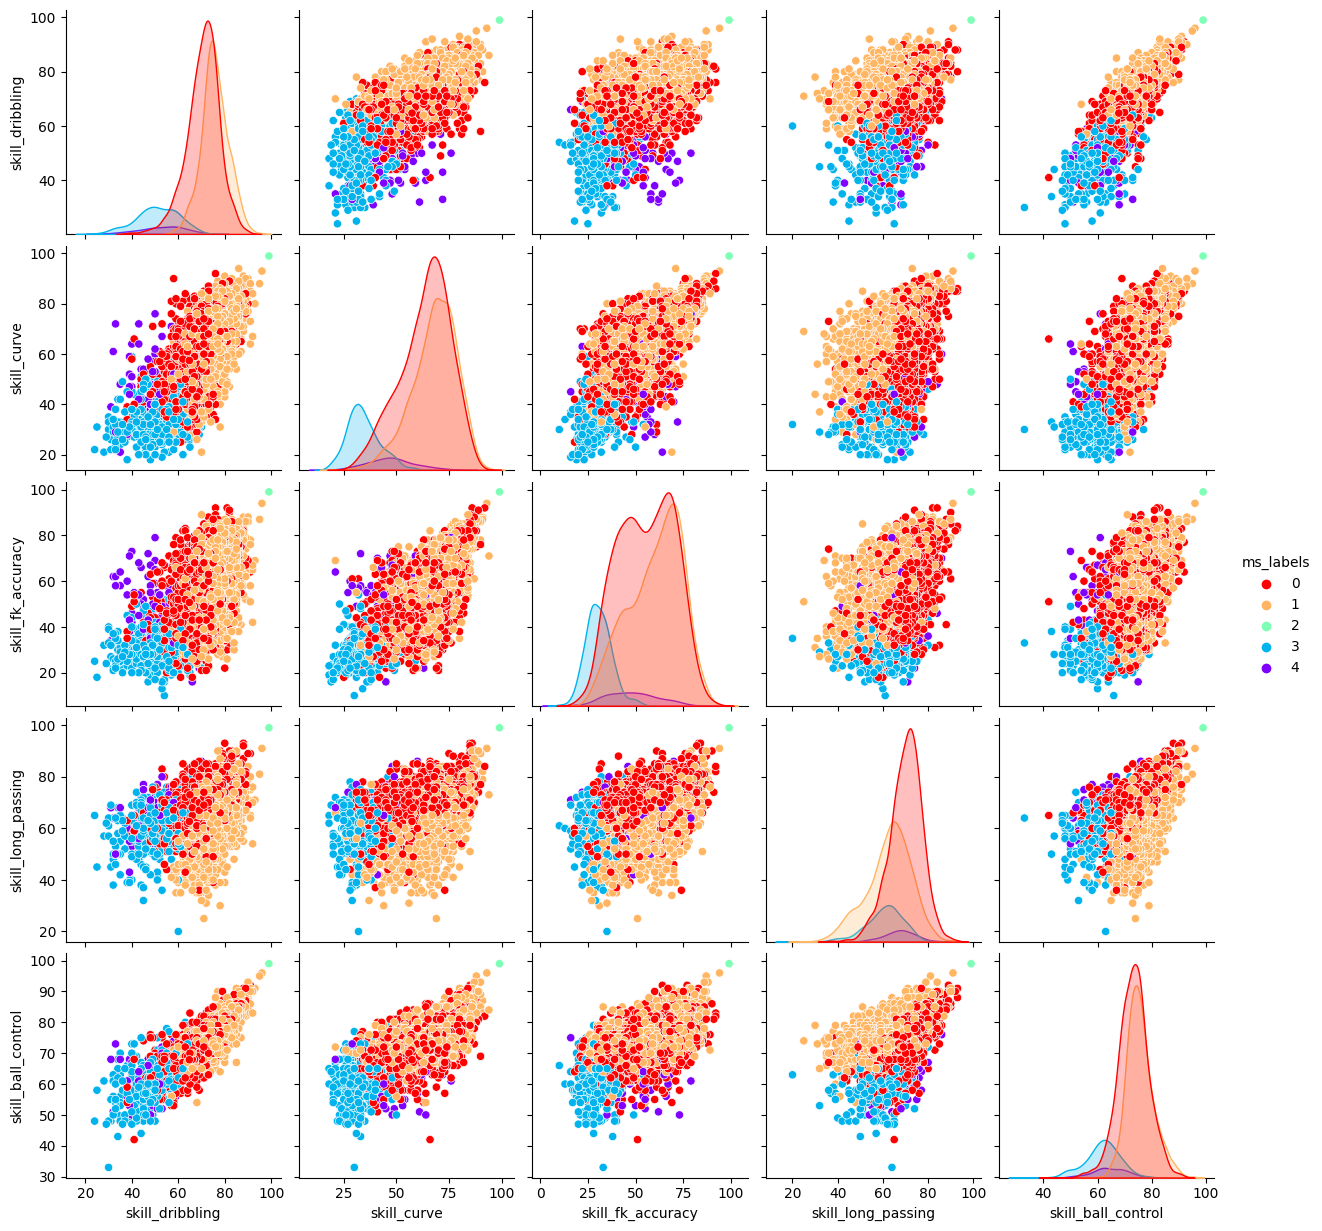

In [ ]:
sns.pairplot(df_clust2[skills_mid],hue ='ms_labels' ,palette = 'rainbow_r');

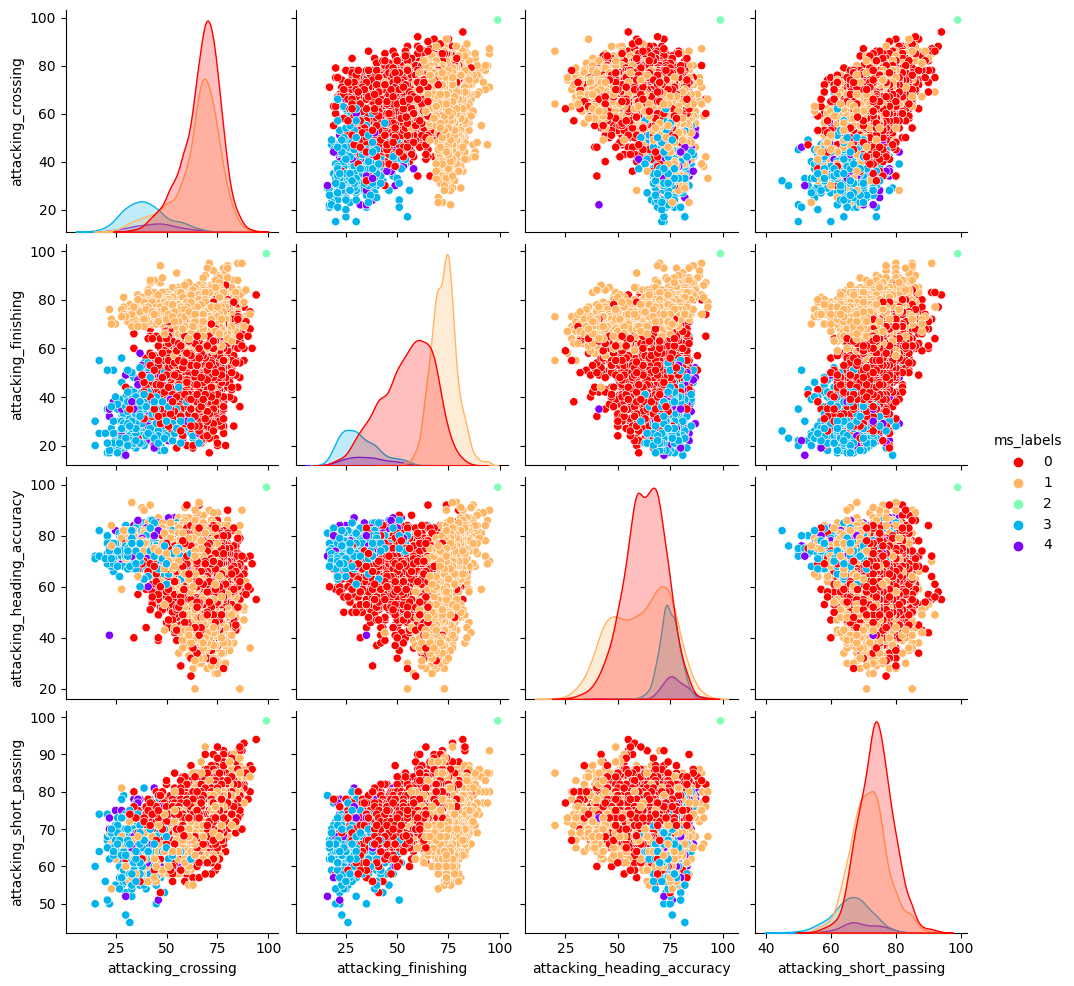

In [ ]:
sns.pairplot(df_clust2[skills_at],hue ='ms_labels' ,palette = 'rainbow_r');

#### ANÁLISIS

In [ ]:
df6 = df_clust2.merge(posiciones2, left_index=True, right_index=True, how='left')

In [ ]:
data_crosstab = pd.crosstab(df6['ms_labels'],
                            df6['Posicion2'], 
                               margins = False)
print(data_crosstab)

Posicion2  Defensor  Delantero  Mediocampista
ms_labels                                    
0               977        107            987
1                 0       1226            329
2                 0          1              0
3               400          0              8
4               108          0              8
